In [1]:
import matplotlib.pyplot as plt
import numpy as np
import kinesis as kn
import gapipes as gp
import astropy.coordinates as coord
import astropy.units as u

In [12]:
import arviz as az

In [275]:
def make_grid_cluster(ra, dec, d, v0, degsize=5.0):
    b0 = coord.ICRS(ra * u.deg, dec * u.deg, d * u.pc).cartesian.xyz.value

    ra_bins = np.linspace(ra - degsize, ra + degsize, 11)
    dec_bins = np.linspace(dec - degsize, dec + degsize, 11)
    ra_grid, dec_grid = np.meshgrid(ra_bins, dec_bins)
    ra_grid = ra_grid.ravel()
    dec_grid = dec_grid.ravel()
    memicrs = coord.ICRS(ra_grid * u.deg, dec_grid * u.deg, [d] * ra_grid.size * u.pc)

    cl = kn.Cluster(v0, .01, b0=b0,).sample_at(memicrs)
    return cl

In [330]:
v0 = np.array([5., 5., 7.07106781])*2
cl1 = make_grid_cluster(45, 45, 100, v0)

#10% error
cov = np.array([np.diag(X) for X in np.abs(cl1.members.truth[['parallax','pmra','pmdec']].values)*0.00001])

irv = np.random.randint(0,cl1.N, size=2)
rv_error = np.array([np.nan]*cl1.N)
rv_error[irv]=0.001
# rv_error = [0.001]*cl1.N
cl1.members.observe(cov=cov, rv_error=rv_error)

In [331]:
model = kn.get_model('general_model')

INFO:kinesis.models:Reading model from disk


In [332]:
D = cl1.members.observed
irv = np.where(D['radial_velocity'].notnull().values)[0]
standata = dict(
    ra=D['ra'].values,
    dec=D['dec'].values,
    a=D[['parallax','pmra','pmdec']].values,
    C=D.g.make_cov(),
    N=len(D),
    Nrv=D['radial_velocity'].notnull().sum(),
    irv=irv,
    rv=D['radial_velocity'].values[irv],
    rv_error=D['radial_velocity_error'].values[irv],
    include_T=1,
    b0=cl1.b0
)
def init():
    return dict(
        d=1e3/D['parallax'],v0=[5,0,7],
        sigv=0.01, T=np.zeros(shape=(1,3,3)),)

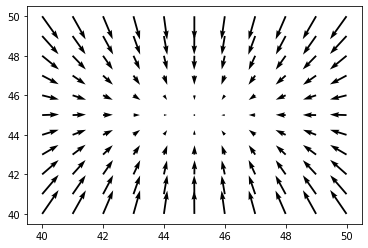

In [334]:
plt.quiver(D['ra'],D['dec'],D['pmra'],D['pmdec']);

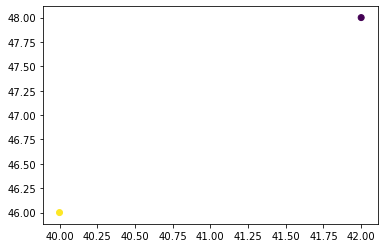

In [335]:
plt.scatter(D['ra'],D['dec'],c=D['radial_velocity']);

In [336]:
r = model.optimizing(data=standata, init=init)

In [337]:
map_soln = r.copy()

In [338]:
map_soln['v0'],map_soln['sigv'], map_soln['T_param']

(array([ 9.99949284,  9.99908767, 14.14001897]),
 array(0.01024443),
 array([[-0.12991396, -0.23336888,  0.23374574],
        [-0.23280193,  0.33911659, -0.07630623],
        [ 0.26916442, -0.2464019 , -0.00216767]]))

In [339]:
kn.decompose_T(map_soln['T_param'])

{'omegax': -0.08504783833534332,
 'omegay': -0.017709338722698337,
 'omegaz': 0.0002834784089035952,
 'w1': -0.1613540637258924,
 'w2': 0.25145507687690194,
 'w3': -0.23308540621482376,
 'w4': array(-0.12991396),
 'w5': array(0.33911659),
 'kappa': 0.06901165492146384}

In [340]:
r = model.sampling(data=standata, init=init, iter=4000)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [341]:
azfit = az.from_pystan(r)

In [342]:
az.summary(azfit, var_names=['v0','sigv','T_param'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],9.985,0.013,9.962,10.009,0.000,0.000,641.0,640.0,642.0,1264.0,1.01
v0[1],9.985,0.013,9.961,10.009,0.001,0.000,640.0,640.0,642.0,1265.0,1.01
v0[2],14.121,0.018,14.088,14.155,0.001,0.001,635.0,635.0,637.0,1346.0,1.01
sigv,0.011,0.001,0.010,0.011,0.000,0.000,2138.0,2128.0,2158.0,3608.0,1.00
"T_param[0,0]",4.259,10.506,-15.476,23.110,0.682,0.483,238.0,238.0,239.0,519.0,1.01
"T_param[0,1]",1.674,10.457,-17.621,21.418,0.683,0.484,234.0,234.0,235.0,481.0,1.01
"T_param[0,2]",7.429,14.667,-19.429,34.719,0.947,0.671,240.0,240.0,240.0,545.0,1.01
"T_param[1,0]",8.366,11.108,-12.849,28.631,0.712,0.504,243.0,243.0,244.0,536.0,1.01
"T_param[1,1]",5.702,10.794,-14.962,25.360,0.706,0.500,234.0,234.0,235.0,556.0,1.01
"T_param[1,2]",12.550,15.382,-15.227,42.387,0.986,0.698,243.0,243.0,244.0,534.0,1.01


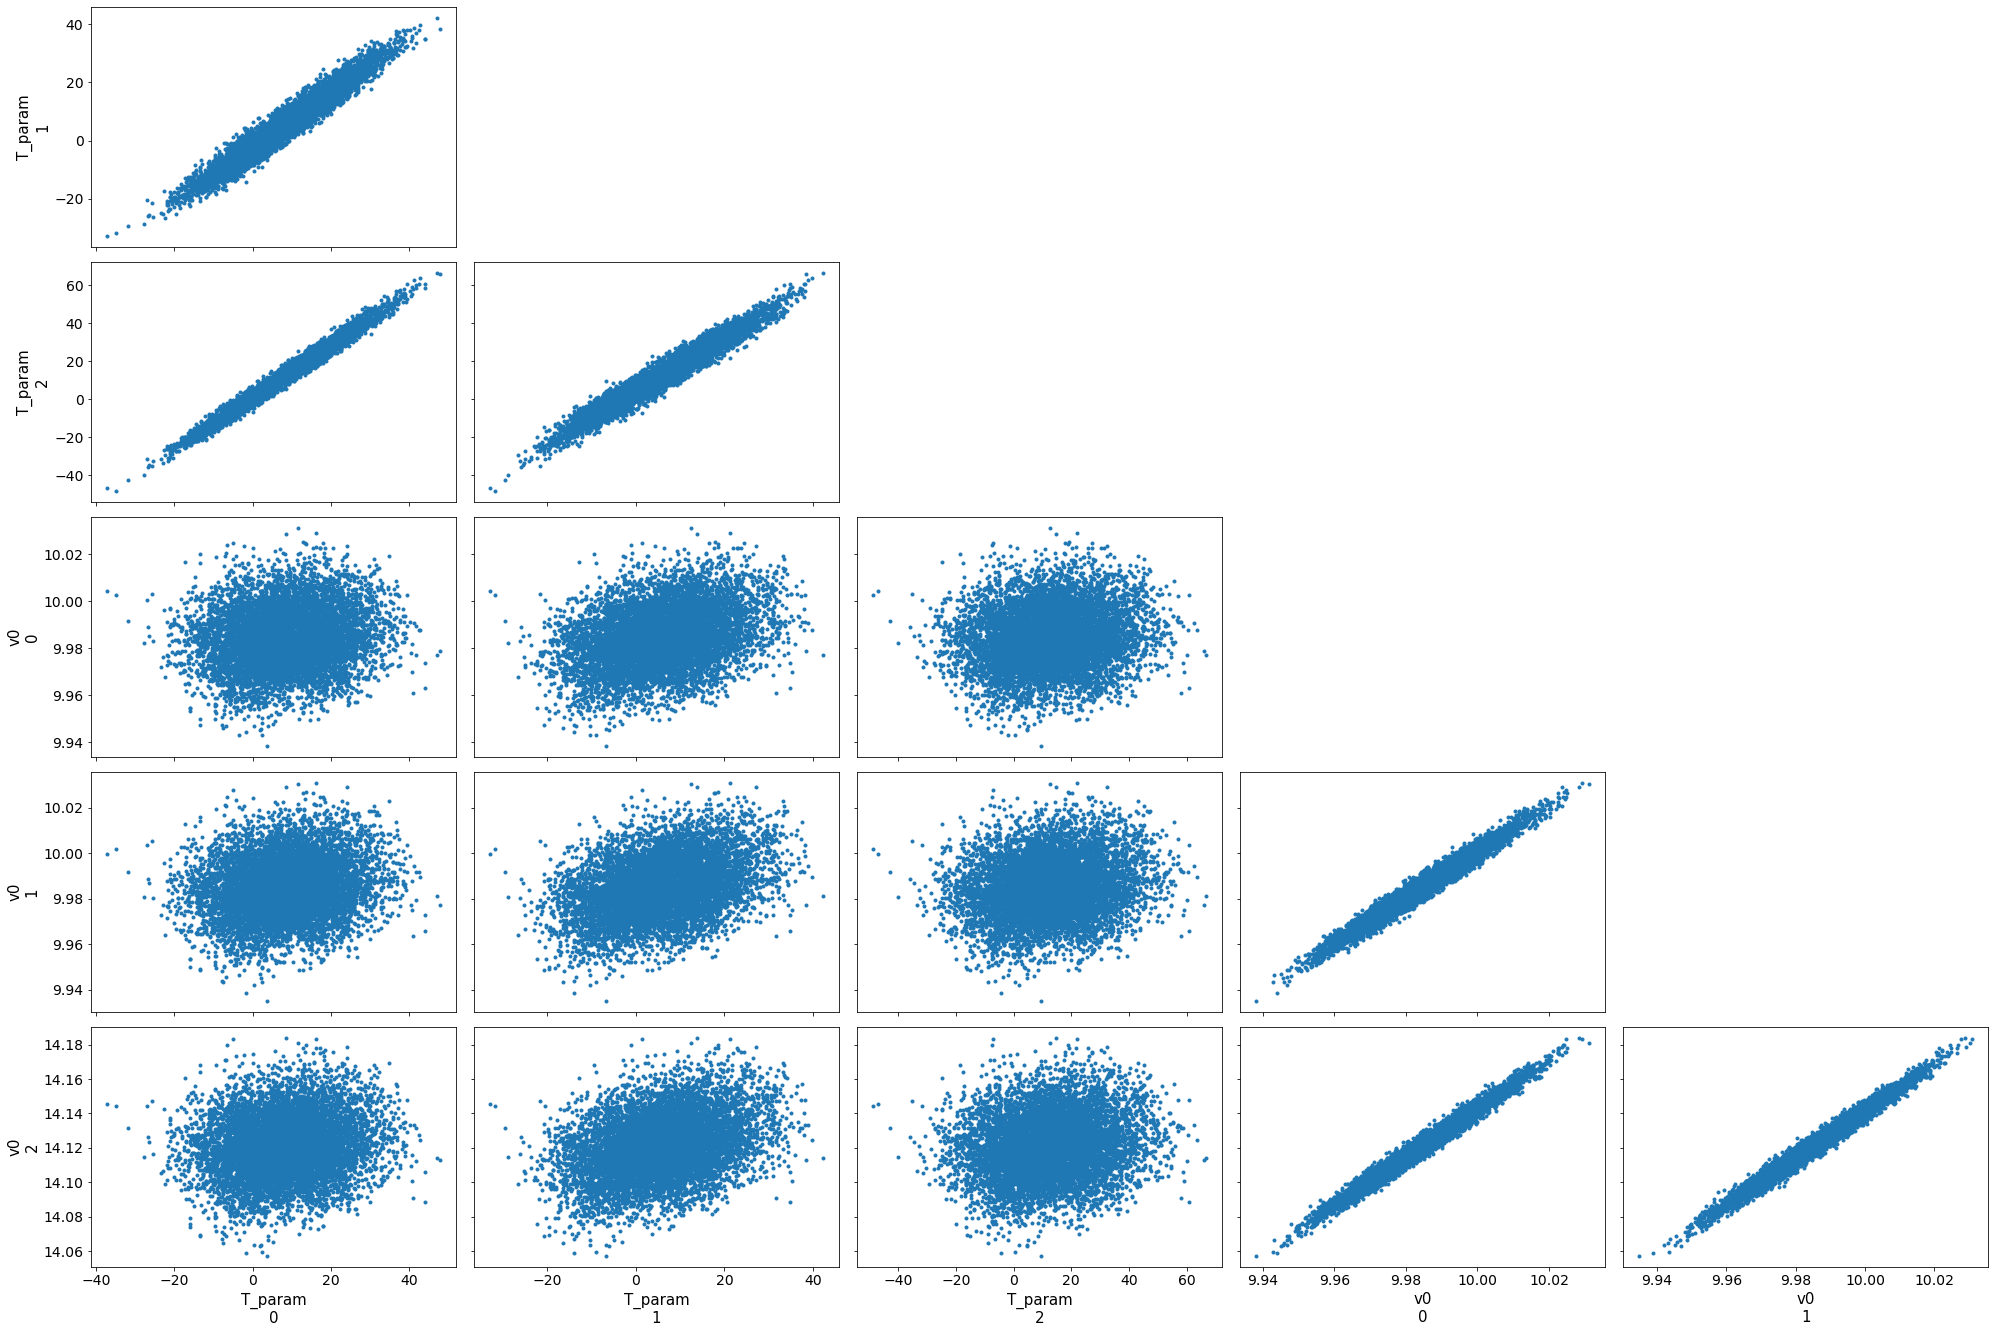

In [343]:
az.plot_pair(azfit, var_names=['T_param','v0'],
             coords=dict(T_param_dim_0=1,T_param_dim_1=[0,1,2],),divergences=True);

In [203]:
from corner import corner

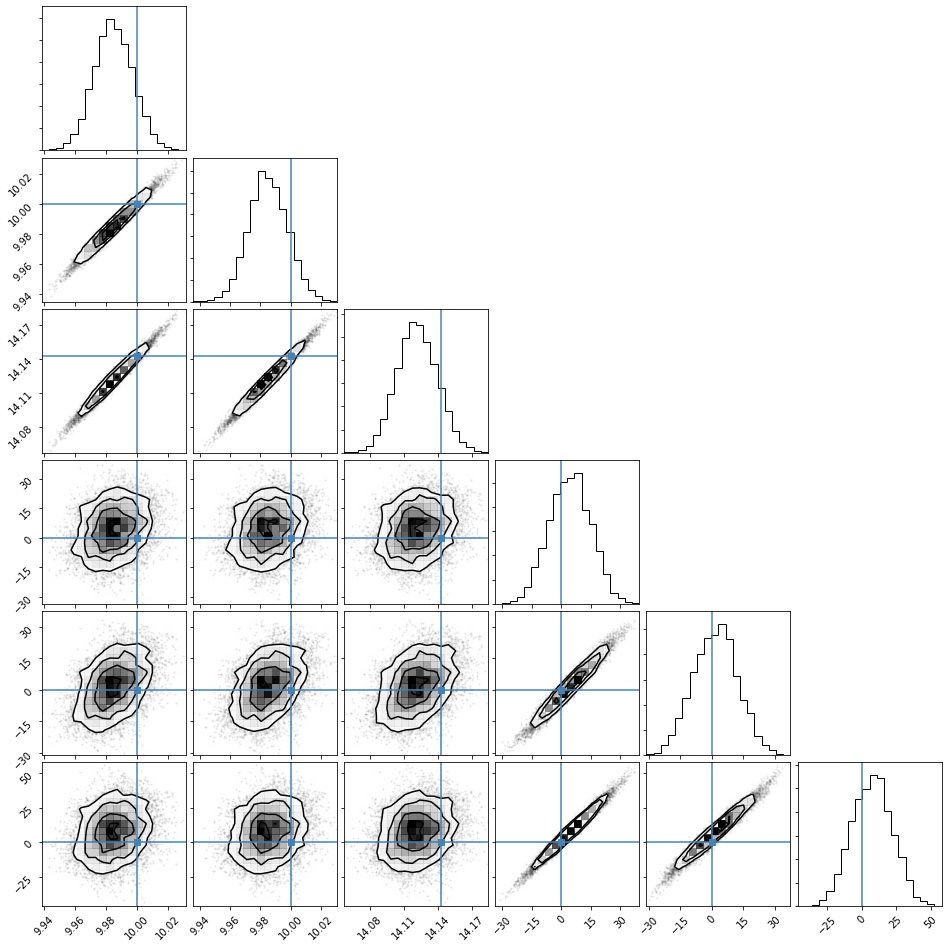

In [344]:
corner(np.concatenate([r['v0'],r['T_param'][:,[0,0,0],[0,1,2]]], axis=1),
    truths=list(v0)+[0]*3);

In [349]:
T=r['T_param']
symT=(np.transpose(T,[0,2,1]) + T)/2.0
antisymT = (T-np.transpose(T, [0,2,1]))

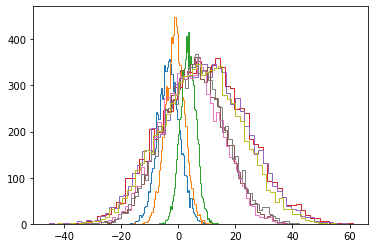

In [350]:
decomT = kn.decompose_T(T)

for k,v in decomT.items():
    plt.hist(v, bins=64, histtype='step')

In [249]:
symT

array([[[46.32966381, 42.73351065, 68.061972  ],
        [42.73351065, 29.50323014, 56.54649188],
        [68.061972  , 56.54649188, 86.69599784]],

       [[46.536411  , 40.88142732, 66.52898554],
        [40.88142732, 30.95711448, 55.70383431],
        [66.52898554, 55.70383431, 91.97699698]],

       [[36.3870201 , 31.86200804, 50.58691223],
        [31.86200804, 26.07823823, 44.70328077],
        [50.58691223, 44.70328077, 69.63293967]],

       ...,

       [[46.96308494, 46.98910693, 69.25165808],
        [46.98910693, 43.04313946, 66.0672059 ],
        [69.25165808, 66.0672059 , 98.68899877]],

       [[20.5133949 , 18.27666721, 29.72390524],
        [18.27666721, 10.69080731, 24.06145094],
        [29.72390524, 24.06145094, 40.32838639]],

       [[27.4934746 , 28.45512019, 44.51006533],
        [28.45512019, 21.09544355, 39.89326749],
        [44.51006533, 39.89326749, 60.57437038]]])

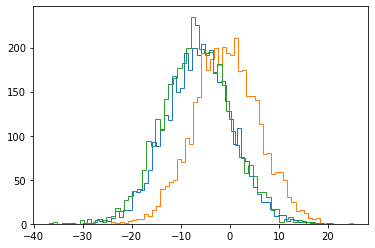

In [253]:
plt.hist(antisymT[:,0,1], bins=64, histtype='step');
plt.hist(antisymT[:,0,2], bins=64, histtype='step');
plt.hist(antisymT[:,2,1], bins=64, histtype='step');

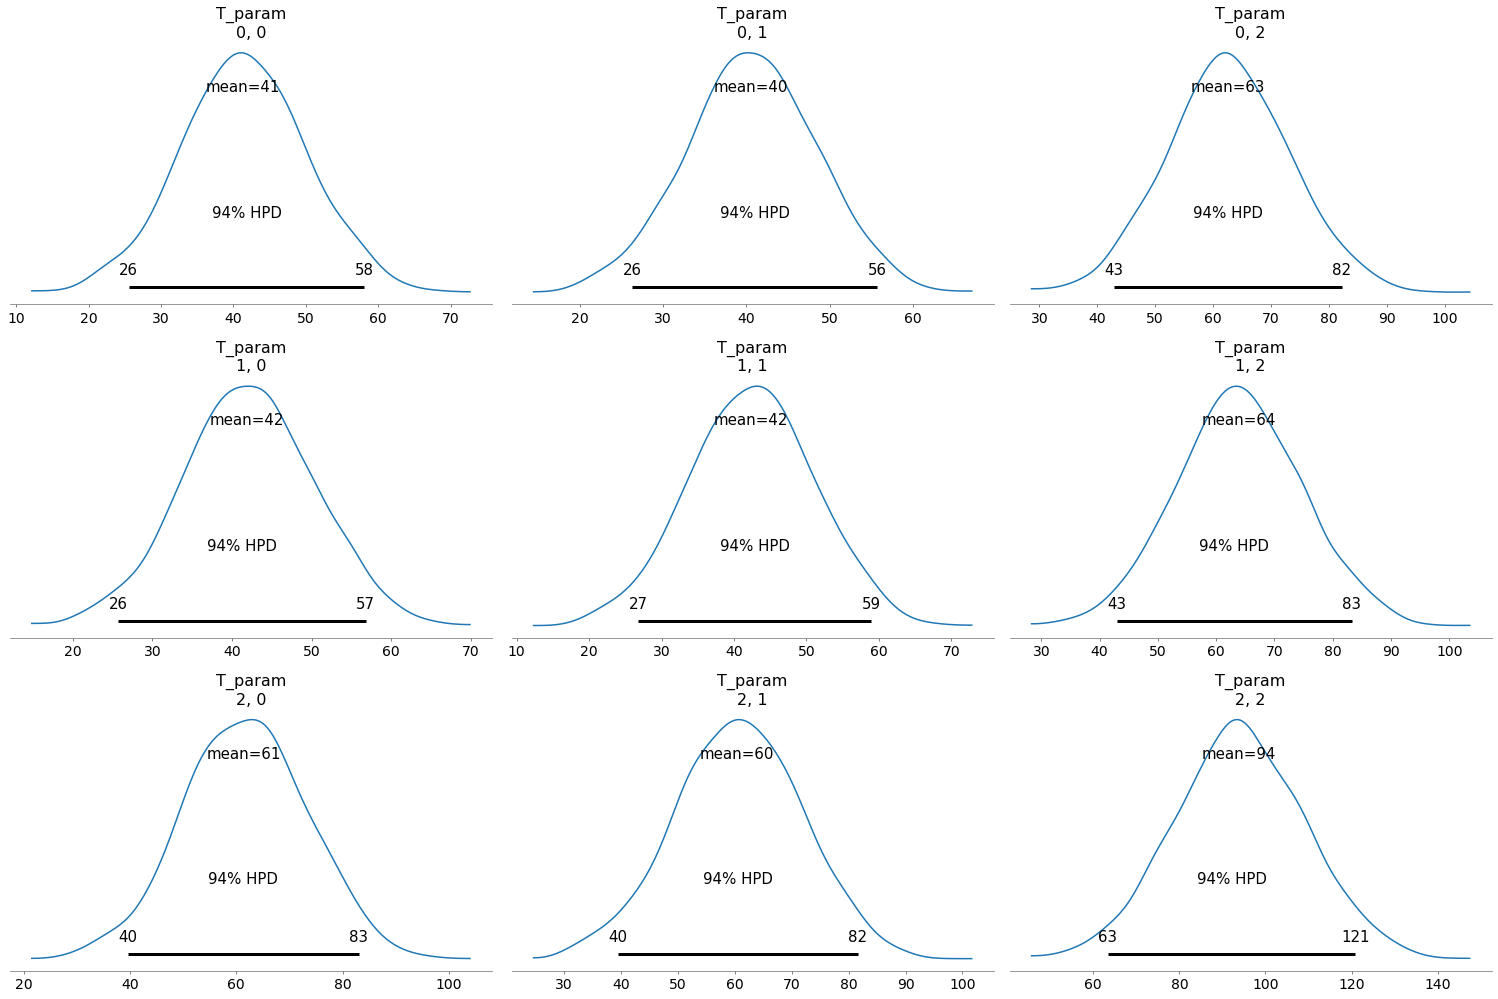

In [199]:
az.plot_posterior(azfit, var_names=['T_param']);